#### By: Peyman Shahidi
#### Created: Nov 11, 2025
#### Last Edit: Nov 11, 2025

<br>

In [160]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [161]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [162]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [163]:
# Read the merged data
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")

# Print number of unique occupations and tasks
print(f"Number of unique occupations: {merged_data['O*NET-SOC Code'].nunique()}")
print(f"Number of unique tasks: {merged_data['Task ID'].nunique()}\n\n")



# Calculate share of occupations without any AI tasks
group = 'O*NET-SOC Code'
merged_data['is_ai_task'] = merged_data['label'].isin(['Automation', 'Augmentation']).astype(int)
ai_task_counts = (
        merged_data.groupby(group)['is_ai_task'].sum()
        .rename('num_ai_tasks').reset_index()
    )
num_occupations_no_ai_tasks = (ai_task_counts['num_ai_tasks'] == 0).sum()
total_occupations = ai_task_counts.shape[0]
share_no_ai_tasks = num_occupations_no_ai_tasks / total_occupations * 100
print(f"Number of occupations without any AI tasks: {num_occupations_no_ai_tasks:,} out of {total_occupations:,}")
print(f"Share of occupations without any AI tasks: {share_no_ai_tasks:.2f}%")

Number of unique occupations: 872
Number of unique tasks: 17920


Number of occupations without any AI tasks: 317 out of 872
Share of occupations without any AI tasks: 36.35%


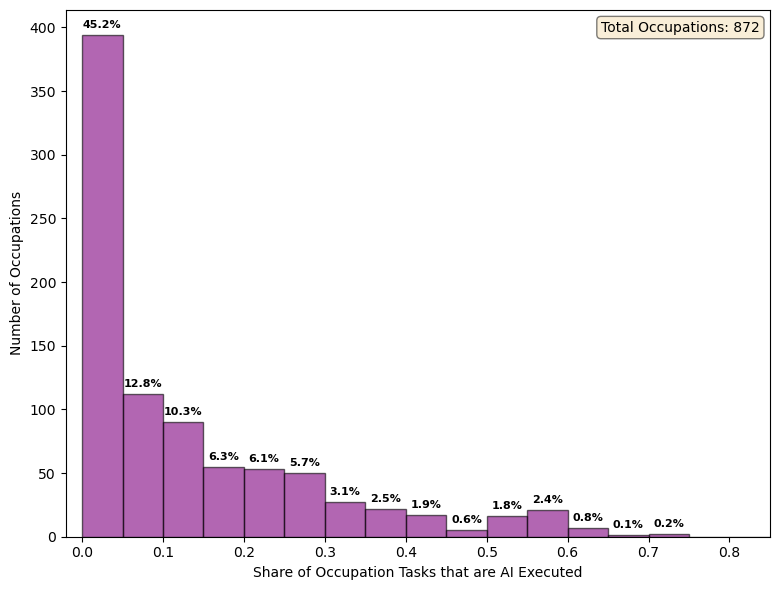

In [164]:
groups_list = ['O*NET-SOC Code'] # ['O*NET-SOC Code', 'Minor_Group_Code', 'Major_Group_Code']
group_labels = ['Occupation'] # ['Occupation', 'Minor Group', 'Major Group']

fig, axes = plt.subplots(1, len(groups_list), figsize=(8 * len(groups_list), 6))

if len(groups_list) == 1:
    axes = [axes]

for ax, group, label in zip(axes, groups_list, group_labels):

    merged_data['is_ai_task'] = merged_data['label'].isin(['Automation', 'Augmentation']).astype(int)

    ai_task_counts = (
        merged_data.groupby(group)['is_ai_task'].sum()
        .rename('num_ai_tasks').reset_index()
    )
    total_task_counts = (
        merged_data.groupby(group)['Task ID'].nunique()
        .rename('total_num_tasks').reset_index()
    )

    ai_task_share = ai_task_counts.merge(total_task_counts, on=group)
    ai_task_share['ai_task_share'] = ai_task_share['num_ai_tasks'] / ai_task_share['total_num_tasks']

    # Plot histogram
    counts, bins, _ = ax.hist(
        ai_task_share['ai_task_share'],
        bins=np.arange(0, 1.1, 0.05),
        edgecolor='black',
        color='purple',
        alpha=0.6
    )
    ax.set_xlabel(f'Share of {label} Tasks that are AI Executed')
    ax.set_ylabel(f'Number of {label}s')
    ax.set_xlim(-0.02, 0.85)

    # Add percentage labels
    total_groups = len(ai_task_share)
    for count, bin_start, bin_end in zip(counts, bins[:-1], bins[1:]):
        if count > 0:
            pct = 100 * count / total_groups
            ax.text(
                (bin_start + bin_end) / 2,
                count + (counts.max() / 100),
                f'{pct:.1f}%',
                ha='center',
                va='bottom',
                fontsize=8,
                fontweight='bold'
            )

    ax.text(
        0.76,
        0.98,
        f'Total {label}s: {total_groups:,}',
        transform=ax.transAxes,
        fontsize=10,
        va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

plt.tight_layout()
plt.savefig(f"{output_plot_path}/ONET_Eloundou_Anthropic_GPT/ai_task_share_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


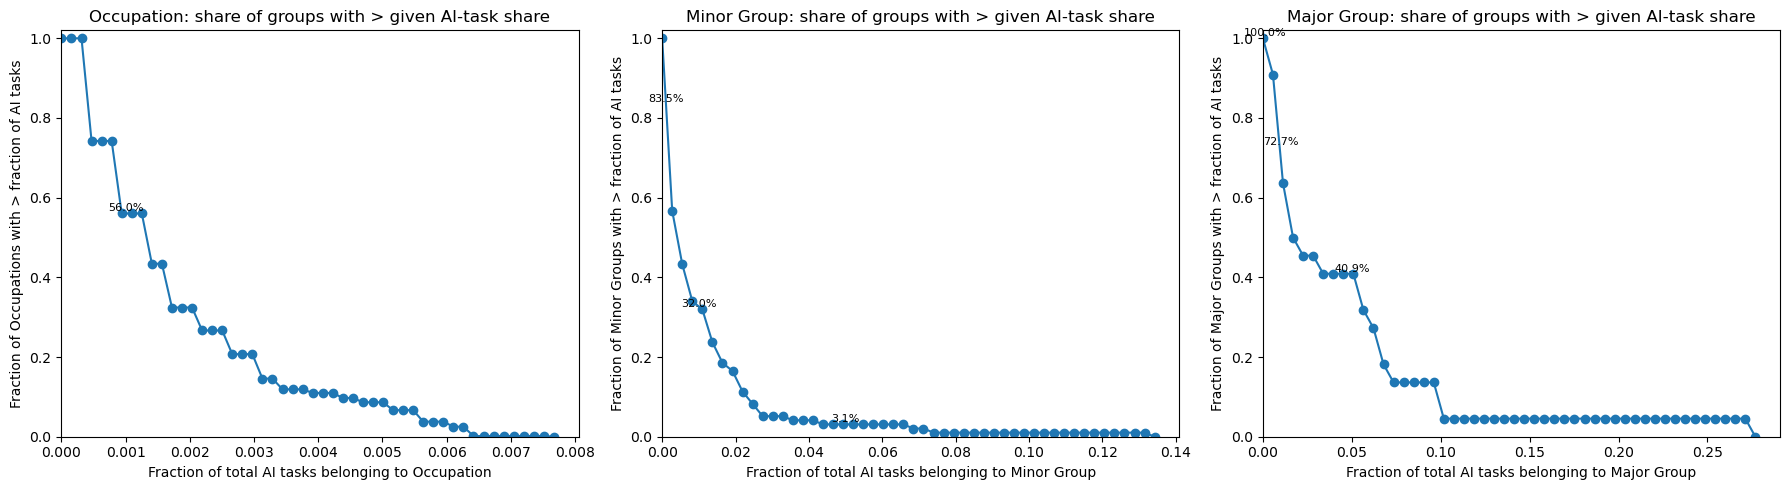

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

groups_list = ['O*NET-SOC Code', 'Minor_Group_Code', 'Major_Group_Code']
group_labels = ['Occupation', 'Minor Group', 'Major Group']

for ax, group, label in zip(axes, groups_list, group_labels):
    # --- 1. Keep only AI tasks ---
    ai_tasks = merged_data[merged_data['label'].isin(['Automation', 'Augmentation'])]

    # --- 2. Count AI tasks per group ---
    ai_counts = (
        ai_tasks.groupby(group)['Task ID']
        .nunique()
        .reset_index(name='num_ai_tasks')
    )

    # --- 3. Compute each group’s share of all AI tasks ---
    total_ai_tasks = ai_counts['num_ai_tasks'].sum()
    ai_counts['ai_task_fraction'] = ai_counts['num_ai_tasks'] / total_ai_tasks

    # --- 4. Compute the share of groups exceeding each fraction threshold ---
    max_frac = ai_counts['ai_task_fraction'].max() if not ai_counts.empty else 0
    ns = np.linspace(0, max_frac, 50)
    total_groups = len(ai_counts)
    fractions = [
        (ai_counts['ai_task_fraction'] > n).sum() / total_groups if total_groups else 0
        for n in ns
    ]

    # --- 5. Plot ---
    ax.plot(ns, fractions, marker='o', linestyle='-')
    ax.set_xlabel(f'Fraction of total AI tasks belonging to {label}')
    ax.set_ylabel(f'Fraction of {label}s with > fraction of AI tasks')
    ax.set_title(f'{label}: share of groups with > given AI-task share')
    ax.set_xlim(0, max_frac * 1.05)
    ax.set_ylim(0, 1.02)

    # Annotate a few thresholds
    for frac_cut in [0.001, 0.01, 0.05]:
        if frac_cut <= max_frac:
            y = (ai_counts['ai_task_fraction'] > frac_cut).sum() / total_groups
            ax.text(frac_cut, y, f'{100*y:.1f}%', fontsize=8, va='bottom', ha='center')

# --- 6. Save plot ---
out_dir = f"{output_plot_path}/ONET_Eloundou_Anthropic_GPT"
os.makedirs(out_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(f"{out_dir}/ai_groups_fraction_over_taskshare.png", dpi=300, bbox_inches='tight')
plt.show()